### Notebook - Table of Content

1. [**Importing necessary libraries**](#1.-Importing-necessary-libraries)   
2. [**Loading data**](#2.-Loading-data) 
3. [**Data preprocessing**](#3.-Data-preprocessing)  
    3.1 [**Removing all the records with Score = 3**](#3.1-Removing-all-the-records-with-Score-=-3)   
    3.2 [**Defining sentiments based on score values**](#3.2-Defining-sentiments-based-on-score-values)   
    3.3 [**Checking for duplicate records**](#3.3-Checking-for-duplicate-records)   
    3.4 [**Checking Data consistency of HelpfulnessNumerator and HelpfulnessDenominator feature**](#3.4-Checking-Data-consistency-of-HelpfulnessNumerator-and-HelpfulnessDenominator-feature)  
    3.5 [**Checking for class imbalance**](#3.5-Checking-for-class-imbalance)  
4. [**Text preprocessing**](#4.-Text-preprocessing)  
5. [**Splitting into train and test set with 80:20 ratio**](#5.-Splitting-into-train-and-test-set-with-80:20-ratio) 
6. [**Model Building**](#6.-Model-Building)   
    6.1 [**Fitting LSTM with Embedding layer**](#6.1-Fitting-LSTM-with-Embedding-layer)  
    6.2 [**Evaluating model performance on test data**](#6.2-Evaluating-model-performance-on-test-data)  

### 1. Importing necessary libraries 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import re
from bs4 import BeautifulSoup
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


### 2. Loading data

In [2]:
df = pd.read_csv("/kaggle/input/amazon-fine-food-reviews/Reviews.csv")
print("Szie of the data : ", df.shape)

Szie of the data :  (568454, 10)


In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### 3. Data preprocessing

#### 3.1 Removing all the records with Score = 3

In [4]:
df_filtered = df[df["Score"]!=3]
df_filtered.shape

(525814, 10)

#### 3.2 Defining sentiments based on score values

In [5]:
df_filtered["Score"] = df_filtered["Score"].apply(lambda x : 1 if x>3 else 0)

#### 3.3 Checking for duplicate records

In [6]:
sorted_data=df_filtered.sort_values('ProductId', kind='quicksort', na_position='last')

In [7]:
final_df=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final_df.shape

(364173, 10)

#### 3.4 Checking Data consistency of HelpfulnessNumerator and HelpfulnessDenominator feature

In [8]:
final_df=final_df[final_df["HelpfulnessNumerator"]<=final_df["HelpfulnessDenominator"]]
final_df.shape

(364171, 10)

#### 3.5 Checking for class imbalance

In [9]:
final_df['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

Text(0.5, 1.0, 'Bar plot of sentiments')

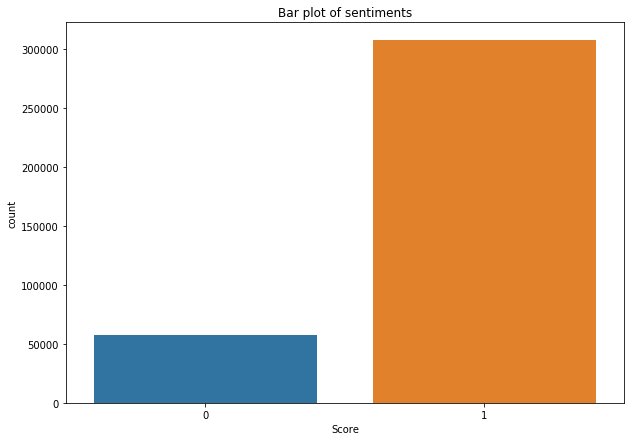

In [10]:
plt.figure(figsize = (10,7))
sns.countplot(final_df['Score'])
plt.title("Bar plot of sentiments")

### 4. Text preprocessing

In this step, following operations are performed on the review text

* Removing website links
* Removing html tags
* Decontracting(expanding from the original form)
* Removing the words with numeric digits
* Removing non-word characters
* Converting to lower case
* Removing stop words
* Performing Lemmatization

In [11]:
def decontract(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

In [12]:
#set of custom stop words
stop_words= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [13]:
lemmatizer = WordNetLemmatizer()

In [14]:
def preprocess_text(review):
    review = re.sub(r"http\S+", "", review)             # removing website links
    review = BeautifulSoup(review, 'lxml').get_text()   # removing html tags
    review = decontract(review)                         # decontracting
    review = re.sub("\S*\d\S*", "", review).strip()     # removing the words with numeric digits
    review = re.sub('[^A-Za-z]+', ' ', review)          # removing non-word characters
    review = review.lower()                             # converting to lower case
    review = [word for word in review.split(" ") if not word in stop_words] # removing stop words
    review = [lemmatizer.lemmatize(token, "v") for token in review] #Lemmatization
    review = " ".join(review)
    review.strip()
    return review
final_df['Text'] = final_df['Text'].apply(lambda x: preprocess_text(x))

In [15]:
final_df['Text'].head()

150523    witty little book make son laugh loud recite c...
150505    grow read sendak book watch really rosie movie...
150506    fun way children learn months year learn poems...
150507    great little book read aloud nice rhythm well ...
150508    book poetry months year go month cute little p...
Name: Text, dtype: object

### 5. Splitting into train and test set with 80:20 ratio

In [16]:
train_df, test_df = train_test_split(final_df, test_size = 0.2, random_state = 42)
print("Training data size : ", train_df.shape)
print("Test data size : ", test_df.shape)

Training data size :  (291336, 10)
Test data size :  (72835, 10)


### 6. Model Building

#### 6.1 Fitting LSTM with Embedding layer

In [17]:
top_words = 6000
tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(train_df['Text'])
list_tokenized_train = tokenizer.texts_to_sequences(train_df['Text'])

max_review_length = 130
X_train = pad_sequences(list_tokenized_train, maxlen=max_review_length)
y_train = train_df['Score']

In [18]:
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 130, 32)           192032    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 245,333
Trainable params: 245,333
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.fit(X_train,y_train, nb_epoch=3, batch_size=64, validation_split=0.2)

Train on 233068 samples, validate on 58268 samples
Epoch 1/3
233068/233068 [==============================] - 664s 3ms/step - loss: 0.2105 - accuracy: 0.9177 - val_loss: 0.1878 - val_accuracy: 0.9253
Epoch 2/3
233068/233068 [==============================] - 662s 3ms/step - loss: 0.1609 - accuracy: 0.9375 - val_loss: 0.1628 - val_accuracy: 0.9363
Epoch 3/3
233068/233068 [==============================] - 660s 3ms/step - loss: 0.1353 - accuracy: 0.9480 - val_loss: 0.1587 - val_accuracy: 0.9392


#### 6.2 Evaluating model performance on test data

In [20]:
list_tokenized_test = tokenizer.texts_to_sequences(test_df['Text'])
X_test = pad_sequences(list_tokenized_test, maxlen=max_review_length)
y_test = test_df['Score']
prediction = model.predict(X_test)
y_pred = (prediction > 0.5)
print("Accuracy of the model : ", accuracy_score(y_pred, y_test))
print('F1-score: ', f1_score(y_pred, y_test))
print('Confusion matrix:')
confusion_matrix(y_test,y_pred)

Accuracy of the model :  0.9388480812796046
F1-score:  0.9641540714987042
Confusion matrix:


array([[ 8481,  2880],
       [ 1574, 59900]])